## Description
A social network company decided to add a feature called: Recommended Friends, i.e. they suggest people you may know. A data scientist has built a model to suggest 5 people to each user. These potential friends will be shown on the user newsfeed. At first, the model is tested just on a random subset of users to see how it performs compared to the newsfeed without the new feature. The test has been running for some time.

The project is to:
Check the results of the test: For each user, check the number of pages visited during their first session since the test started. If this number increased, the test is a success.

Specifically, answer the following 3 questions:
1) Is the test winning? 
2) Is the test performing similarly for all user segments or are there differences among different segments?
3) If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?

## Index
* [Load Data](#load-data)
* [Question 1: Is the test winning?](#question-1)
* [Question 2: Is the test performing similarly for all user segments?](#question-2)
    * [1) Browser](#1-browser)
    * [2) New/Existing User](#2-newexisting-user)
* [Question 3: What could be the reason? Would this change the conclusion?](#question-3)


In [97]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.stats import ttest_ind

%matplotlib inline

### Load data

In [98]:
# Load user data
user = pd.read_csv('user_table.csv')
user['signup_date'] = pd.to_datetime(user['signup_date'])
user.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [99]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      100000 non-null  int64         
 1   signup_date  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.5 MB


In [100]:
# Load test data
test = pd.read_csv('test_table.csv')
test['date'] = pd.to_datetime(test['date'])
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [101]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        100000 non-null  int64         
 1   date           100000 non-null  datetime64[ns]
 2   browser        100000 non-null  object        
 3   test           100000 non-null  int64         
 4   pages_visited  100000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.8+ MB


In [102]:
# Join user and test table
df = pd.merge(left = user, right = test, on = 'user_id', how = 'left')
df.head()

,user_id,signup_date,date,browser,test,pages_visited
0,34,2015-01-01,2015-08-15,Chrome,0,6
1,59,2015-01-01,2015-08-12,Chrome,1,6
2,178,2015-01-01,2015-08-10,Safari,1,3
3,285,2015-01-01,2015-08-03,Opera,0,5
4,383,2015-01-01,2015-08-05,Firefox,1,9


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        100000 non-null  int64         
 1   signup_date    100000 non-null  datetime64[ns]
 2   date           100000 non-null  datetime64[ns]
 3   browser        100000 non-null  object        
 4   test           100000 non-null  int64         
 5   pages_visited  100000 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 4.6+ MB


### Question 1 
**Is the test winning?**

In [104]:
# Get average pages visited in each group
df.groupby('test')['pages_visited'].mean()

test
0    4.608394
1    4.599693
Name: pages_visited, dtype: float64

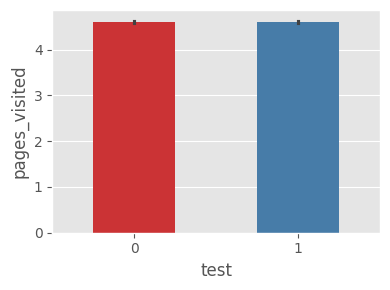

In [105]:
# Visualisation
fig, ax = plt.subplots(figsize=(4, 3))
palette = sns.color_palette("Set1", 2)
sns.barplot(x='test', y='pages_visited', data=df, ax=ax, width = 0.5, palette=palette)
plt.tight_layout()
plt.show()

In [106]:
# Perform t-test
control_page = df[df['test'] == 0]['pages_visited'].values              # Convert the column selected into a numpy array
experiment_page = df[df['test'] == 1]['pages_visited'].values
ttest_ind(a=control_page, b=experiment_page, equal_var=False)

Ttest_indResult(statistic=0.5571118435554797, pvalue=0.5774523171559118)

From the above analysis, we find that the p-value is `0.577`, which is much larger than `0.05`. Therefore, we cannot reject the null hypothesis that there is no difference between the control and experiment groups.

Thus, the test does not show a significant difference and it should not be expanded to all users.

### Question 2
**Is the test performing similarly for all user segments or are there differences among different segments?**

### 1) Browser

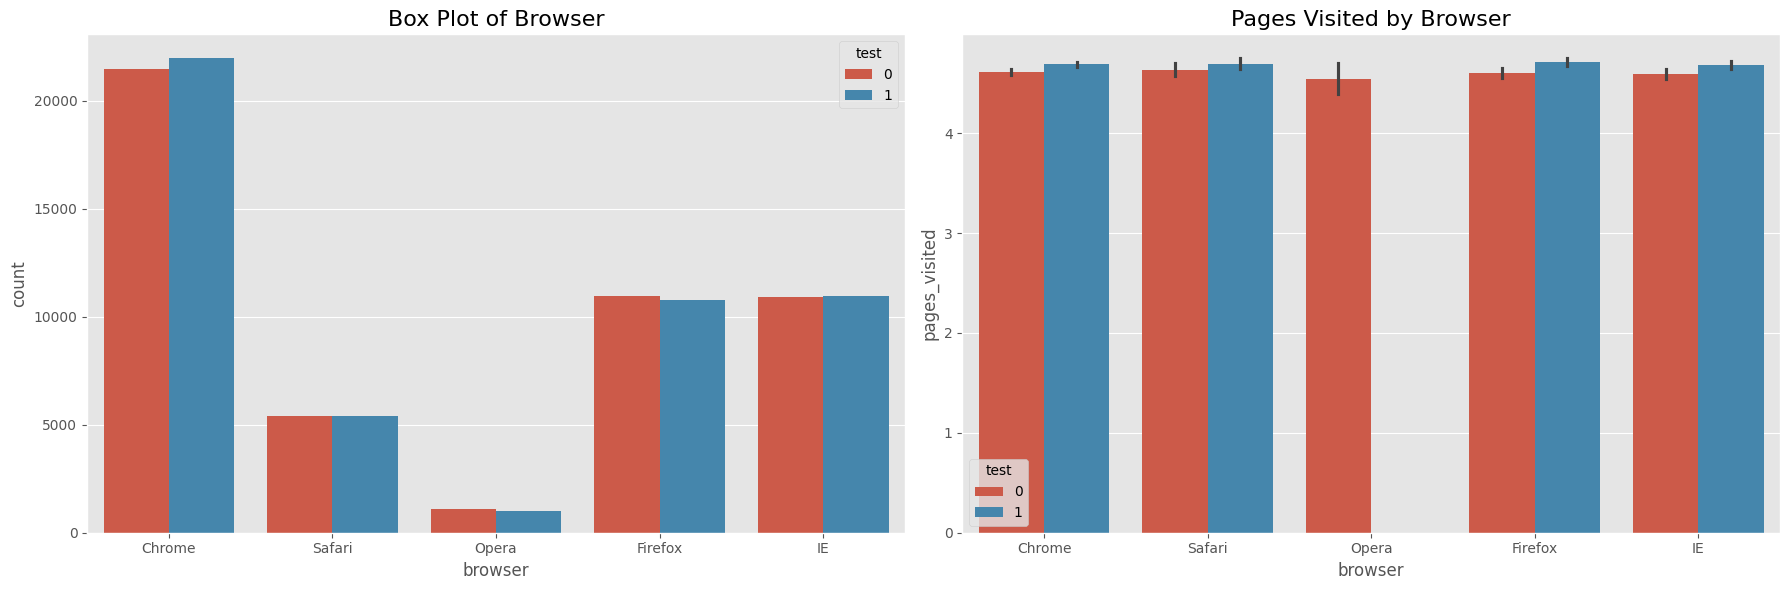

In [107]:
# visualisation of browser
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=df, ax=ax[0])
ax[0].set_title('Box Plot of Browser', fontsize=16)

sns.barplot(x='browser', y='pages_visited', hue='test', data=df, ax=ax[1])
ax[1].set_title('Pages Visited by Browser', fontsize=16)
plt.tight_layout()
plt.show()

- Observation:
1. The majority of users use Chrome, followed by Firefox, IE, Safari and Opera. The distribution of users between the test and control groups appears similar within each browser segment.
2. For Chrome, Safari, Firefox and Internet Explorer (IE), the test group shows slightly higher average pages visited compared to the control group. This indicates a positive impact of the feature on these browsers.
3. For Opera, the test group has zero pages visited. This is unusual given that there are 1,018 users in the test group who use Opera. Further investigation is needed to find out the reason.

In [108]:
# Check Browser Opera's test performance
Opera_test_size = df[(df['browser'] == 'Opera')&(df['test'] == 1)].shape[0]
Opera_pages_visited = df[(df['browser'] == 'Opera')&(df['test'] == 1)]['pages_visited'].sum()
print('Opera test size:', Opera_test_size)
print('Pages visited by Opera users in test group:', Opera_pages_visited)

Opera test size: 1018
Pages visited by Opera users in test group: 0


### 2) New/Existing User

In [109]:
# Create new_user column
df['interval'] = (df['date'] - df['signup_date']).dt.days
df['new_user'] = (df['interval'] == 0).astype(int)
df.head()

,user_id,signup_date,date,browser,test,pages_visited,interval,new_user
0,34,2015-01-01,2015-08-15,Chrome,0,6,226,0
1,59,2015-01-01,2015-08-12,Chrome,1,6,223,0
2,178,2015-01-01,2015-08-10,Safari,1,3,221,0
3,285,2015-01-01,2015-08-03,Opera,0,5,214,0
4,383,2015-01-01,2015-08-05,Firefox,1,9,216,0


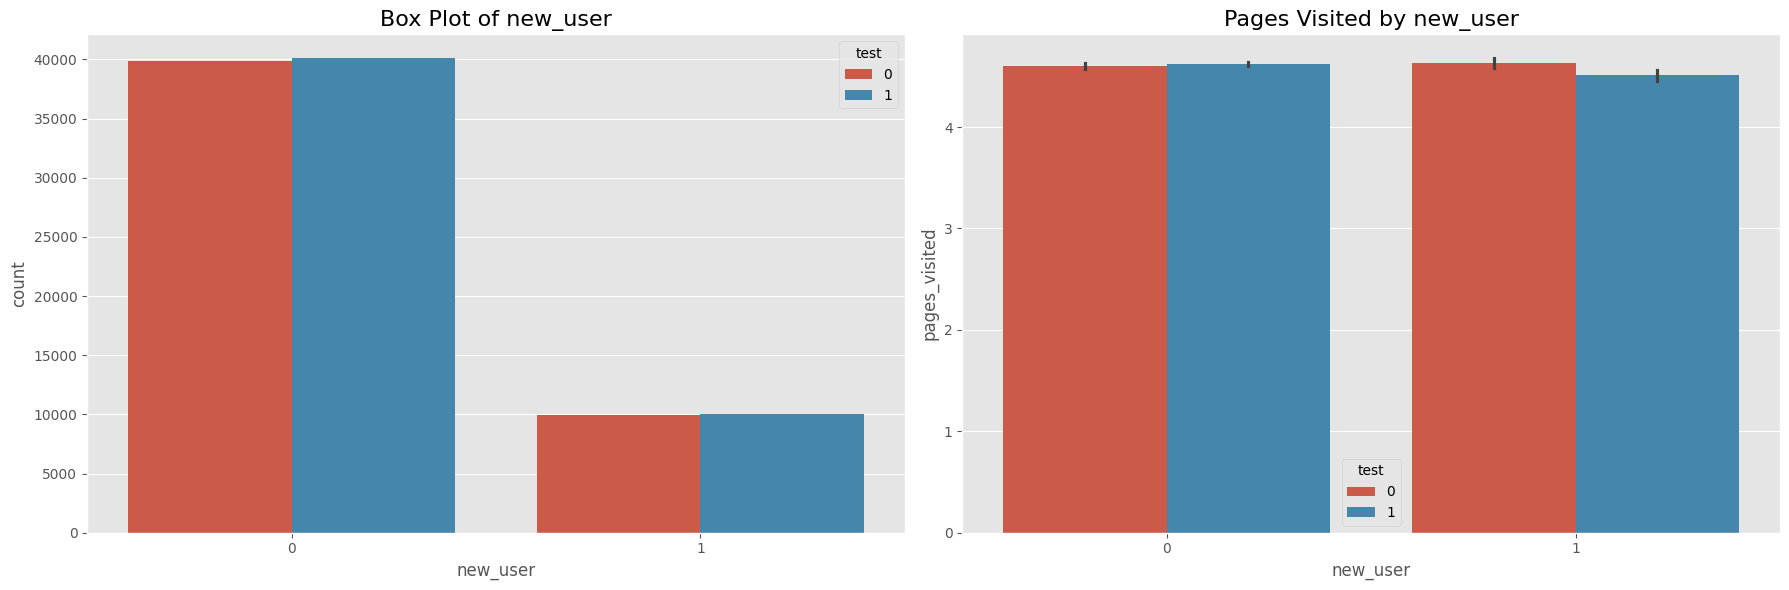

In [110]:
# Visualisation of new_user
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='test', data=df, ax=ax[0])
ax[0].set_title('Box Plot of new_user', fontsize=16)

sns.barplot(x='new_user', y='pages_visited', hue='test', data=df, ax=ax[1])
ax[1].set_title('Pages Visited by new_user', fontsize=16)
plt.tight_layout()
plt.show()


- Observation:

For new users who visit the website right after signing up, the test group has a lower average pages visited compared to the control group. The new feature seems to have a negative impact on the engagement of new users.

### Question 3
**If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?**

From the above analysis, we find that the number of pages visited increased for Chrome, Safari, Firefox and IE, but the number of pages visited is always 0 for Opera, which shows that there might be some errors or bugs.
To figure out if this factor led to the failure of the test, I will remove the users of Opera and conduct the t-test again.

In [111]:
df2 = df[df['browser'] != 'Opera']
df2.groupby('test')['pages_visited'].mean()

test
0    4.609804
1    4.694989
Name: pages_visited, dtype: float64

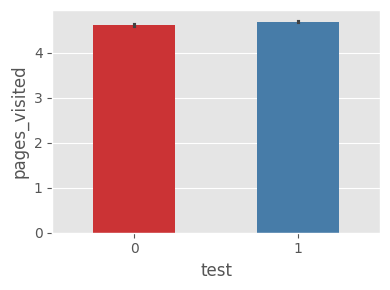

In [112]:
# Visualization
fig, ax = plt.subplots(figsize=(4, 3))
palette = sns.color_palette("Set1", 2)
sns.barplot(x='test', y='pages_visited', data=df2, ax=ax, width=0.5, palette=palette)
plt.tight_layout()
plt.show()

In [113]:
# Perform t-test
control_page2 = df2[df2['test'] == 0]['pages_visited'].values
experiment_page2 = df2[df2['test'] == 1]['pages_visited'].values
ttest_ind(a=control_page2, b=experiment_page2, equal_var=False)

Ttest_indResult(statistic=-5.474295518566027, pvalue=4.403954129457701e-08)

- Observation: 

After removing the records with Opera browser, the new feature becomes significantly useful. Therefore, I would suggest expanding this feature to the other browser users.

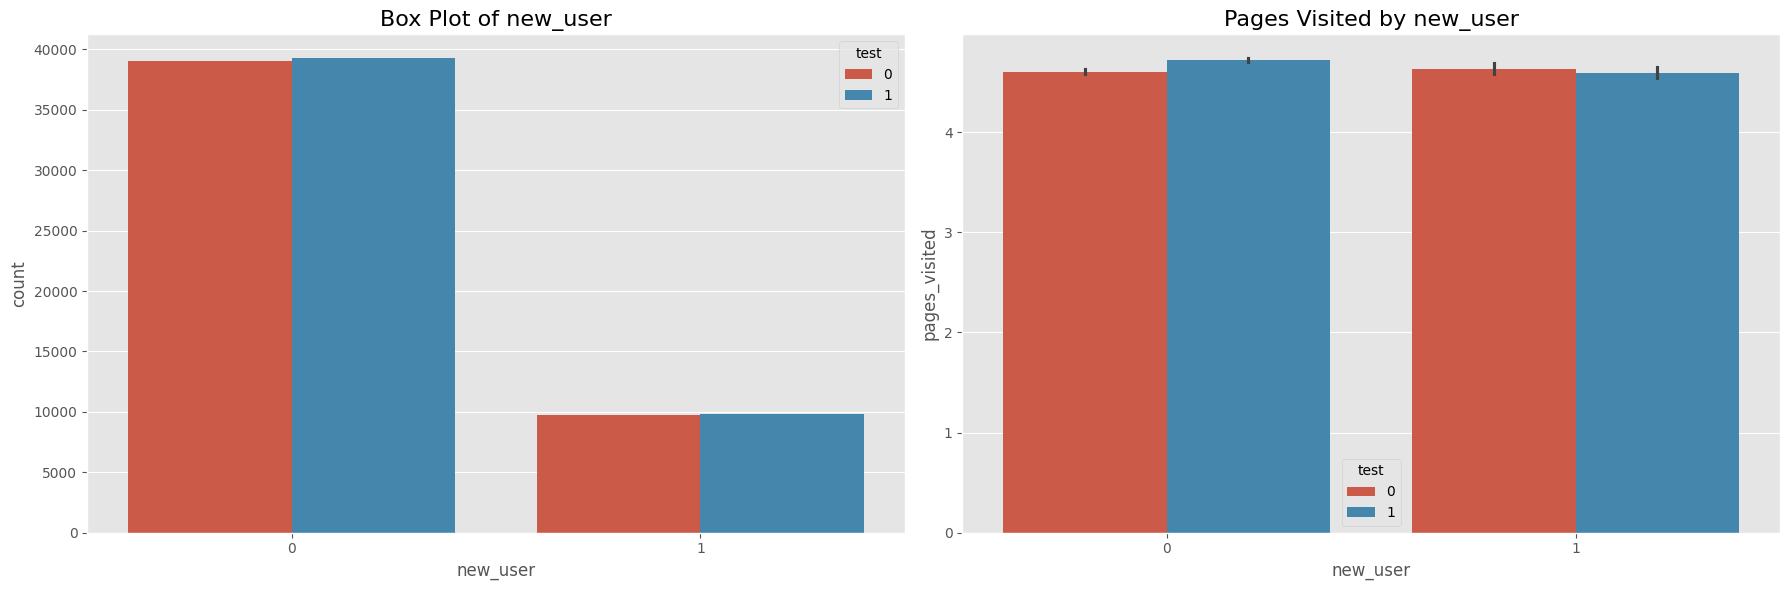

In [114]:
# Visualisation of new_user
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='test', data=df2, ax=ax[0])
ax[0].set_title('Box Plot of new_user', fontsize=16)

sns.barplot(x='new_user', y='pages_visited', hue='test', data=df2, ax=ax[1])
ax[1].set_title('Pages Visited by new_user', fontsize=16)
plt.tight_layout()
plt.show()

- Observation: 

After removing the data of Opera browser, there is still a drop in the number of pages visited by the new user group after applying this new feature.

This might be because the friend recommendation engine relies on a user's past activity on the site. Since new users don't have any previous history, the recommendations may seem random and not very interesting to them. Also, the space taken up by the recommended friends on the page could slightly reduce the number of pages these new users visit. From the observation, the Recommedation Engine suffers the `cold start problem`.